# Lazily Accessing Remotely Stored Data

*Note*

To get started, you will need to need to install `requests` and `aiohttp`

In this tutorial, we will go through how to access an :class:`~anndata.AnnData` object from a remote store using new functionality, experimental :func:`anndata.experimental.read_backed` + :func:`anndata.experimental.read_elem_lazy` functions.  The same idea, loading data lazily with minimal overhead on request, also applies to on-disk data.  Broadly then, this is a new way of accessing what was has been called "`backed`" data previously. Let's get started.

In [1]:
from anndata.experimental import read_backed, read_elem_lazy
import anndata as ad
import fsspec, zarr
import scanpy as sc
import os

%load_ext autoreload
%autoreload 2

First we set up a custom store for tracking how many requests we are making.  This is just a light wrapper around LRUStoreCache that prints when a key has been accessed.

In [2]:
class AccessTrackingStore(zarr.LRUStoreCache):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def __getitem__(self, key):
        if key not in self._values_cache:
            print(key)
        return super().__getitem__(key)

In [3]:
mapper = fsspec.get_mapper(
    "https://vitessce-demo-data.storage.googleapis.com/anndata-demos/BALF_VIB-UGent_processed_cleaned.zarr/"
)
store = AccessTrackingStore(mapper, max_size=2**28)

In [4]:
adata = read_backed(store)

.zmetadata


<frozen abc>:106: FutureWarning: xarray subclass Dataset2D should explicitly define __slots__


obs/_index/7
obs/_index/6
obs/_index/5
obs/_index/4
obs/_index/3
obs/_index/2
obs/_index/1
obs/_index/0
var/_index/0
obs/SARS-CoV-2 PCR/7
obs/SARS-CoV-2 PCR/6
obs/SARS-CoV-2 PCR/5
obs/SARS-CoV-2 PCR/4
obs/SARS-CoV-2 PCR/3
obs/SARS-CoV-2 PCR/2
obs/SARS-CoV-2 PCR/1
obs/SARS-CoV-2 PCR/0
obs/28-day death/7
obs/28-day death/6
obs/28-day death/5
obs/28-day death/4
obs/28-day death/3
obs/28-day death/2
obs/28-day death/1
obs/28-day death/0
layers/X_csc/indices/.zarraylayers/X_csc/indices/.zarray

layers/X_csc/indices/.zarray
layers/X_csc/indptr/.zarray
layers/X_csc/indptr/.zarray
layers/X_csc/indptr/.zarray
layers/X_csc/indptr/0
layers/X_csc/indptr/0
layers/X_csc/indptr/0
layers/X_csc/data/961
layers/X_csc/data/158
layers/X_csc/data/404
layers/X_csc/indices/480
layers/X_csc/indices/202
layers/X_csc/indices/79
obsm/X_umap/3.1
obsm/X_umap/3.0
obsm/X_umap/2.1
obsm/X_umap/2.0
obsm/X_umap/1.1
obsm/X_umap/1.0
obsm/X_umap/0.1
obsm/X_umap/0.0


/Users/ilangold/Projects/Theis/anndata/venv/lib/python3.12/site-packages/dask/array/chunk.py:278: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
/Users/ilangold/Projects/Theis/anndata/venv/lib/python3.12/site-packages/dask/array/chunk.py:278: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
/Users/ilangold/Projects/Theis/anndata/venv/lib/python3.12/site-packages/dask/array/chunk.py:278: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
/Users/ilangold/Projects/Theis/anndata/venv/lib/python3.12/site-packages/dask/array/chunk.py:278: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
/Users/ilangold/Projects/Theis/anndata/venv/lib/python3.12/site-packages/dask/array/chunk.py:278: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
/Users/ilangold/Projects/Theis/anndata/venv/lib/py

In [5]:
adata

AnnData object with n_obs × n_vars = 275056 × 24740
    obs: 'orig.ident', 'Age', 'Sex', 'Race', 'Ethnicity', 'BMI', 'Pre-existing heart disease', 'Pre-existing lung disease', 'Pre-existing kidney disease', 'Pre-existing diabetes', 'Pre-existing hypertension', 'Pre-existing immunocompromised condition', 'Smoking', 'SARS-CoV-2 PCR', 'SARS-CoV-2 Ab', 'Symptomatic', 'Admitted to hospital', 'Highest level of respiratory support', 'Vasoactive agents required during hospitalization', '28-day death', '28-day outcome', 'Disease classification', 'Organ System', 'Source', 'Days since hospital admission', 'SOFA', 'Technology', 'Method', 'CITE-Seq panel', 'Reference', 'Institute', 'Creation date', 'Annotation'
    var: 'feature_type', 'gene_id'
    obsm: 'X_umap'
    layers: 'X_csc'

Great! We can see that with only a few requests, we can now view all the columns available in this new `AnnData` object.  This is a great start towards understanding what our data is.

Immediately, we see that this is some sort of COVID-19 dataset (from https://www.covid19cellatlas.org/index.patient.html, "Bronchoalveolar lavage fluid").  Now, let's try to do some science and see how this new object works.

Note the type of  `obs` - a subclass (with minimal changes) of :class:`xarray.Dataset`. This API gives AnnData a familiar feeling dataframe API to :class:`pandas.DataFrame` while keeping things lazy-loaded.

In [6]:
adata.obs

obs/orig.ident/categories/0
obs/Age/categories/0
obs/Sex/categories/0
obs/Race/categories/0
obs/Ethnicity/categories/0
obs/BMI/categories/0
obs/Smoking/categories/0
obs/28-day outcome/categories/0
obs/Organ System/categories/0
obs/Source/categories/0
obs/Technology/categories/0
obs/Method/categories/0
obs/CITE-Seq panel/categories/0
obs/Reference/categories/0
obs/Institute/categories/0
obs/Annotation/categories/0


<xarray.Dataset2D> Size: 75MB
Dimensions:                                            (obs_names: 275056)
Coordinates:
  * obs_names                                          (obs_names) object 2MB ...
Data variables: (12/33)
    orig.ident                                         (obs_names) category 2MB ...
    Age                                                (obs_names) category 2MB ...
    Sex                                                (obs_names) category 2MB ...
    Race                                               (obs_names) category 2MB ...
    Ethnicity                                          (obs_names) category 2MB ...
    BMI                                                (obs_names) category 2MB ...
    ...                                                 ...
    Method                                             (obs_names) category 2MB ...
    CITE-Seq panel                                     (obs_names) category 2MB ...
    Reference                                          (obs_names) category 2MB ...
    Institute                                          (obs_names) category 2MB ...
    Creation date                                      (obs_names) float64 2MB dask.array<chunksize=(34382,), meta=np.ndarray>
    Annotation                                         (obs_names) category 2MB ...

In [7]:
adata.obs["SARS-CoV-2 PCR"]

<xarray.DataArray 'SARS-CoV-2 PCR' (obs_names: 275056)> Size: 2MB
dask.array<from-zarr, shape=(275056,), dtype=float64, chunksize=(34382,), chunktype=numpy.ndarray>
Coordinates:
  * obs_names  (obs_names) object 2MB 'COV002_AAACCCAAGAGTCTTC-1' ... 'COV037...

In [8]:
adata.obs["28-day death"]

<xarray.DataArray '28-day death' (obs_names: 275056)> Size: 2MB
dask.array<from-zarr, shape=(275056,), dtype=float64, chunksize=(34382,), chunktype=numpy.ndarray>
Coordinates:
  * obs_names  (obs_names) object 2MB 'COV002_AAACCCAAGAGTCTTC-1' ... 'COV037...

These are both :class:`xarray.DataArray`s, with `Dask` backing data.  We'll use these columns to form an interesting subset.  Usually we would hope these are stored as boolean, but floats will work just the same.  Note that the indexing data needs to be in memory first before it can be used.  This will likely be improved in the future.  So let's start by getting just the COVID-19 positive patients - we'll separate by mortality later.

In [25]:
adata.obs["SARS-CoV-2 PCR"].astype("bool").data

dask.array<astype, shape=(275056,), dtype=bool, chunksize=(34382,), chunktype=numpy.ndarray>

In [26]:
has_covid = adata.obs["SARS-CoV-2 PCR"].astype("bool")
has_covid_adata = adata[has_covid, :]
has_covid_adata

View of AnnData object with n_obs × n_vars = 140014 × 24740
    obs: 'orig.ident', 'Age', 'Sex', 'Race', 'Ethnicity', 'BMI', 'Pre-existing heart disease', 'Pre-existing lung disease', 'Pre-existing kidney disease', 'Pre-existing diabetes', 'Pre-existing hypertension', 'Pre-existing immunocompromised condition', 'Smoking', 'SARS-CoV-2 PCR', 'SARS-CoV-2 Ab', 'Symptomatic', 'Admitted to hospital', 'Highest level of respiratory support', 'Vasoactive agents required during hospitalization', '28-day death', '28-day outcome', 'Disease classification', 'Organ System', 'Source', 'Days since hospital admission', 'SOFA', 'Technology', 'Method', 'CITE-Seq panel', 'Reference', 'Institute', 'Creation date', 'Annotation'
    var: 'feature_type', 'gene_id'
    obsm: 'X_umap'
    layers: 'X_csc'

That was pretty fast!  Now we're getting somewhere.  Let's look at the cell types present in our dataset.

We immediately are able to see the available categories here.  Not too much data has been read in yet - only  what we need.  COVID 19 is known to act (https://pubmed.ncbi.nlm.nih.gov/34861051/) on CD4, Neutorphil and CD8+ cells inversely in suriviors vs. non-surivivors, so let's focus on those.

In [10]:
has_covid_adata.obs["Annotation"].data.categories

obs/Annotation/codes/0
obs/Annotation/codes/1


Index(['B cell', 'Baso Mast', 'CD4+ T-cell', 'CD8+ T-cell', 'Doublet',
       'Epithelial cell', 'Macrophage', 'Macrophage:Alveolar', 'NK',
       'Neutrophil', 'Plasma cell', 'cDC', 'gd T-cell', 'pDC'],
      dtype='object')

In [11]:
affected_cell_types = ["CD4+ T-cell", "CD8+ T-cell", "Neutrophil"]

In [29]:
# Note we have to load the data into memory via .data[()] in order to index the AnnData object
affected_cell_types_adata = has_covid_adata[
    has_covid_adata.obs["Annotation"].isin(affected_cell_types), :
]
has_covid_adata

View of AnnData object with n_obs × n_vars = 140014 × 24740
    obs: 'orig.ident', 'Age', 'Sex', 'Race', 'Ethnicity', 'BMI', 'Pre-existing heart disease', 'Pre-existing lung disease', 'Pre-existing kidney disease', 'Pre-existing diabetes', 'Pre-existing hypertension', 'Pre-existing immunocompromised condition', 'Smoking', 'SARS-CoV-2 PCR', 'SARS-CoV-2 Ab', 'Symptomatic', 'Admitted to hospital', 'Highest level of respiratory support', 'Vasoactive agents required during hospitalization', '28-day death', '28-day outcome', 'Disease classification', 'Organ System', 'Source', 'Days since hospital admission', 'SOFA', 'Technology', 'Method', 'CITE-Seq panel', 'Reference', 'Institute', 'Creation date', 'Annotation'
    var: 'feature_type', 'gene_id'
    obsm: 'X_umap'
    layers: 'X_csc'

We can now check the claim of the above-linked paper.  They claim "At admission, patients who later succumbed to COVID-19 had significantly lower frequencies of all memory CD8+ T cell subsets, resulting in increased CD4-to-CD8 T cell and neutrophil-to-CD8 T cell ratios."  Is this true?  We can check very easily! Indeed it is!

In [30]:
died = has_covid_adata.obs["28-day death"].astype("bool")

In [31]:
cd8 = has_covid_adata.obs["Annotation"] == "CD8+ T-cell"
cd4 = has_covid_adata.obs["Annotation"] == "CD4+ T-cell"
neutrophil = has_covid_adata.obs["Annotation"] == "Neutrophil"

cd8_count_survived = has_covid_adata[cd8 & ~died, :].shape[0]
cd4_count_survived = has_covid_adata[cd4 & ~died, :].shape[0]
neutrophil_count_survived = has_covid_adata[neutrophil & ~died, :].shape[0]

cd8_count_mortality = has_covid_adata[cd8 & died, :].shape[0]
cd4_count_mortality = has_covid_adata[cd4 & died, :].shape[0]
neutrophil_count_mortality = has_covid_adata[neutrophil & died, :].shape[0]

In [32]:
print("Patients who Survived:")
print("----------------------")
print(f"CD4/CD8 Ratio: {cd4_count_survived / cd8_count_survived}")
print(f"Neutrophil/CD8 Ratio: {neutrophil_count_survived / cd8_count_survived}")

Patients who Survived:
----------------------
CD4/CD8 Ratio: 1.4132880871584212
Neutrophil/CD8 Ratio: 6.4724057867476334


In [33]:
print("Patients who Died:")
print("----------------------")
print(f"CD4/CD8 Ratio: {cd4_count_mortality / cd8_count_mortality}")
print(f"Neutrophil/CD8 Ratio: {neutrophil_count_mortality / cd8_count_mortality}")

Patients who Died:
----------------------
CD4/CD8 Ratio: 2.9249146757679183
Neutrophil/CD8 Ratio: 14.858788395904437


Remarkable, we immediately see that this dataset confirms that result reported.  And this short confirmatory analysis all took place without every loading the omics data (from `X`) into memory. Indeed, all of the above code should cumulatively have taken no longer than 15 seconds to run.  But what if we do want to look at the raw omics data?  Let's try to do that, using a few cell-type markers reported from this dataset: https://www.medrxiv.org/content/10.1101/2020.11.20.20227355v1.full.pdf.  These should appear clearly across certain cell types when visualized.

Before we go further to visualize gene expression, let's note the size of the chunks for `X_csc` (which we will use to visualize gene expression because it is column-efficient) - these are quite large for fetching individual columns as we will do below.  However, a larger chunk size can be beneficial for other applications, such as PCA, where big groups of row data (ideally from dense or CSR matrices) is likely better than tiny chunks as hte overhead of individual fetch calls is reduced.

In [17]:
adata.layers["X_csc"]

dask.array<make_dask_chunk, shape=(275056, 24740), dtype=float64, chunksize=(275056, 1000), chunktype=scipy.csc_matrix>

To fix this problem, let's re-read the data with smaller chunk sizes via `read_elem_lazy`.  This will reduce overhead without incurring any cost.

In [18]:
adata.layers["X_csc"] = read_elem_lazy(zarr.open(store)["layers"]["X_csc"], chunks=(adata.shape[0], 1))
adata.layers["X_csc"]

.zgroup
layers/.zarray
layers/.zgroup
layers/X_csc/.zarray
layers/X_csc/.zgroup
layers/X_csc/.zattrs
layers/X_csc/data/.zarray
layers/X_csc/__dask_tokenize__/.zarray
layers/X_csc/__dask_tokenize__/.zgroup


dask.array<make_dask_chunk, shape=(275056, 24740), dtype=float64, chunksize=(275056, 1), chunktype=scipy.csc_matrix>

In [19]:
genes = ["MUC5AC", "FOXP3", "CTLA4"]
gene_subset_adata = adata[:, genes]
gene_subset_adata

View of AnnData object with n_obs × n_vars = 275056 × 3
    obs: 'orig.ident', 'Age', 'Sex', 'Race', 'Ethnicity', 'BMI', 'Pre-existing heart disease', 'Pre-existing lung disease', 'Pre-existing kidney disease', 'Pre-existing diabetes', 'Pre-existing hypertension', 'Pre-existing immunocompromised condition', 'Smoking', 'SARS-CoV-2 PCR', 'SARS-CoV-2 Ab', 'Symptomatic', 'Admitted to hospital', 'Highest level of respiratory support', 'Vasoactive agents required during hospitalization', '28-day death', '28-day outcome', 'Disease classification', 'Organ System', 'Source', 'Days since hospital admission', 'SOFA', 'Technology', 'Method', 'CITE-Seq panel', 'Reference', 'Institute', 'Creation date', 'Annotation'
    var: 'feature_type', 'gene_id'
    obsm: 'X_umap'
    layers: 'X_csc'

Now we want to visualize the data.  But we need to bring the data into memory for that.  Luckily, this is no problem as there is a convenient `to_memory` function provided with the `AnnData` object.  Also, we once again note the presence of an `X_csc` layer - the `X` layer is sparse `CSR` format which will not be very good for reading column data efficiently.  Thus we use the `X_csc` matrix for fast access to full cell information given a subset of genes of interest. 

In [20]:
obs_keys_to_exclude = [
    v for v in gene_subset_adata.obs.keys() if v != "Annotation"
]
data_for_memory = ad.AnnData(
    obs = gene_subset_adata.obs.drop_vars(obs_keys_to_exclude),
    obsm = gene_subset_adata.obsm,
    var = gene_subset_adata.var.drop_vars(list(gene_subset_adata.var.keys())),
    X = gene_subset_adata.layers["X_csc"]
) 
gene_subset_adata_in_memory = data_for_memory.to_memory()

Note the data accessed - basically only UMAP coordinates and a few chunks of the underlying sparse data.  The above should have only taken about 5 seconds.  Finally, we can use this in-memory object in `scanpy` to visualize the data.  Indeed, the genes only show up in subsets of the clusers because the paper reports a finer grained cell typing than is given in the `AnnData` object.  For example, from the paper, "preliminary phenotyping of CD4 T cell subsets revealed...regulatory (FOXP3, CTLA4)....cells."  And indeed, we see those genes appearing within, but not overall in, the CD4+ T-Cell cluster.

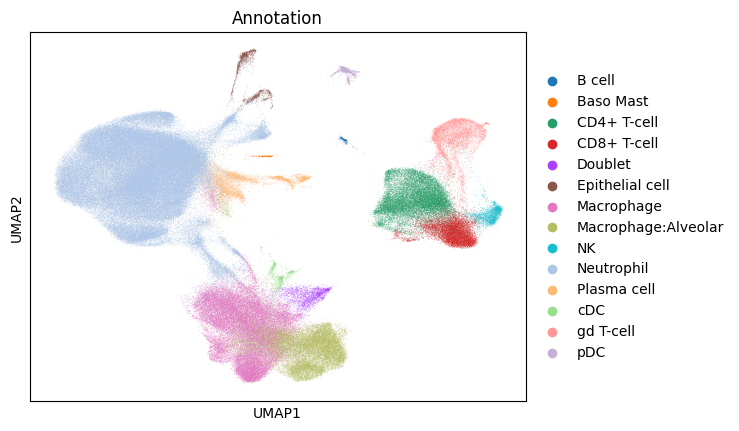

In [21]:
sc.pl.umap(gene_subset_adata_in_memory, color="Annotation")

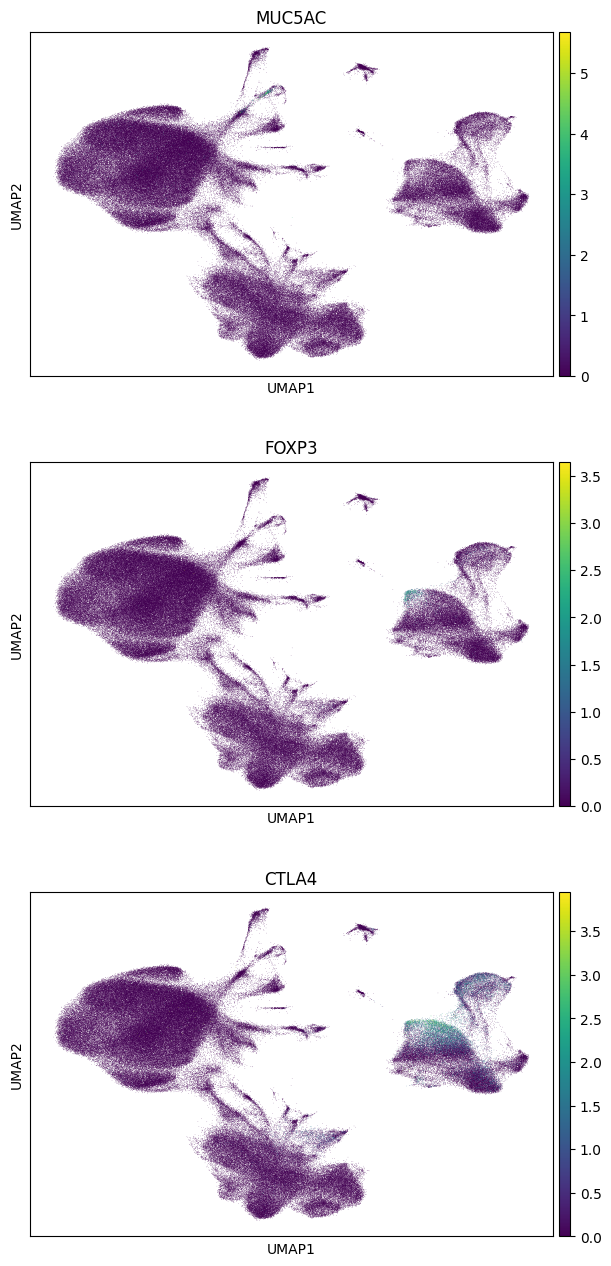

In [22]:
sc.pl.umap(gene_subset_adata_in_memory, color=genes, ncols=1)

Lastly, note that if you were to rerun the notebook without restarting the kernel, you would load no data in.  That is because we used an `LRUStoreCache` for the `zarr` data, so the data is cached.  In total the above notebook should not have taken more than 30 seconds to run.  This enables a new way of accessing `anndata` data that is either too far away or too big to fit into memory.

In the future, we will work on enabling `xarray` across `X`, `obsm`, and all other attributes to give a truly unified API (currently, the `obsm`, `varp` etc. classes are still the same, albeit lazy).  Furthermore, we hope to allow for point-to-point writing as well as overwriting i.e., without having to read the data into memory.  Onwards!